# Regression Week 5: Feature Selection and LASSO (Interpretation)

In this notebook, you will use LASSO to select features, building on a pre-implemented solver for LASSO (using Turi Create, though you can use other solvers). You will:
* Run LASSO with different L1 penalties.
* Choose best L1 penalty using a validation set.
* Choose best L1 penalty using a validation set, with additional constraint on the size of subset.

In the second notebook, you will implement your own LASSO solver, using coordinate descent. 

# Fire up Turi Create

In [1]:
import turicreate

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [2]:
sales = turicreate.SFrame('~/my-env/1_Regression/data/home_data.sframe/')

# Create new features

As in Week 2, we consider features that are some transformations of inputs.

In [3]:
from math import log, sqrt
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']

# In the dataset, 'floors' was defined with type string, 
# so we'll convert them to float, before creating a new feature.
sales['floors'] = sales['floors'].astype(float) 
sales['floors_square'] = sales['floors']*sales['floors']

* Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this variable will mostly affect houses with many bedrooms.
* On the other hand, taking square root of sqft_living will decrease the separation between big house and small house. The owner may not be exactly twice as happy for getting a house that is twice as big.

# Learn regression weights with L1 penalty

Let us fit a model with all the features available, plus the features we just created above.

In [4]:
all_features = ['bedrooms', 'bedrooms_square',
                'bathrooms',
                'sqft_living', 'sqft_living_sqrt',
                'sqft_lot', 'sqft_lot_sqrt',
                'floors', 'floors_square',
                'waterfront', 'view', 'condition', 'grade',
                'sqft_above',
                'sqft_basement',
                'yr_built', 'yr_renovated']

Applying L1 penalty requires adding an extra parameter (`l1_penalty`) to the linear regression call in Turi Create. (Other tools may have separate implementations of LASSO.)  Note that it's important to set `l2_penalty=0` to ensure we don't introduce an additional L2 penalty.

In [5]:
model_all = turicreate.linear_regression.create(sales, target='price', features=all_features,
                                                validation_set=None, 
                                                l2_penalty=0., l1_penalty=1e10)

Linear regression:

--------------------------------------------------------

Number of examples          : 21613

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Max Error | Training Root-Mean-Square Error |

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

| 0         | 1        | 1.000000  | 1.013927     | 7700000.000000     | 653047.733994                   |

| 1         | 2        | 0.000002  | 1.261459     | 6962915.603493     | 426631.749026                   |

| 2         | 3        | 0.000002  | 1.284415     | 6843144.200219     | 392488.929838                   |

| 3         | 4        | 0.000002  | 1.310076     | 6831900.032123     | 385340.166783                   |

| 4         | 5        | 0.000002  | 1.330846     | 6847166.848958     | 384842.383767                   |

| 5         | 6        | 0.000002  | 1.361617     | 6869667.895833     | 385998.458623                   |

| 10        | 11       | 0.000002  | 1.474860     | 6842123.232651     | 364204.576180                   |

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

Completed (Iteration limit reached).

This model may not be optimal. To improve it, consider increasing `max_iterations`.

Find what features had non-zero weight.

In [6]:
model_all.coefficients

name,index,value,stderr
(intercept),None,274873.05595049576,None
bedrooms,None,0.0,None
bedrooms_square,None,0.0,None
bathrooms,None,8468.531086910105,None
sqft_living,None,24.42072098244546,None
sqft_living_sqrt,None,350.06055338605546,None
sqft_lot,None,0.0,None
sqft_lot_sqrt,None,0.0,None
floors,None,0.0,None
floors_square,None,0.0,None


In [7]:
model_all.coefficients.print_rows(18,4)

+------------------+-------+--------------------+--------+
|       name       | index |       value        | stderr |
+------------------+-------+--------------------+--------+
|   (intercept)    |  None | 274873.05595049576 |  None  |
|     bedrooms     |  None |        0.0         |  None  |
| bedrooms_square  |  None |        0.0         |  None  |
|    bathrooms     |  None | 8468.531086910105  |  None  |
|   sqft_living    |  None | 24.42072098244546  |  None  |
| sqft_living_sqrt |  None | 350.06055338605546 |  None  |
|     sqft_lot     |  None |        0.0         |  None  |
|  sqft_lot_sqrt   |  None |        0.0         |  None  |
|      floors      |  None |        0.0         |  None  |
|  floors_square   |  None |        0.0         |  None  |
|    waterfront    |  None |        0.0         |  None  |
|       view       |  None |        0.0         |  None  |
|    condition     |  None |        0.0         |  None  |
|      grade       |  None | 842.0680348976231  |  None 

Note that a majority of the weights have been set to zero. So by setting an L1 penalty that's large enough, we are performing a subset selection. 

***QUIZ QUESTION***:
According to this list of weights, which of the features have been chosen? 

# Selecting an L1 penalty

To find a good L1 penalty, we will explore multiple values using a validation set. Let us do three way split into train, validation, and test sets:
* Split our sales data into 2 sets: training and test
* Further split our training data into two sets: train, validation

Be *very* careful that you use seed = 1 to ensure you get the same answer!

In [8]:
(training_and_validation, testing) = sales.random_split(.9,seed=1) # initial train/test split
(training, validation) = training_and_validation.random_split(0.5, seed=1) # split training into train and validate

Next, we write a loop that does the following:
* For `l1_penalty` in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, type `np.logspace(1, 7, num=13)`.)
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list.
    * Compute the RSS on VALIDATION data (here you will want to use `.predict()`) for that `l1_penalty`
* Report which `l1_penalty` produced the lowest RSS on validation data.

When you call `linear_regression.create()` make sure you set `validation_set = None`.

Note: you can turn off the print out of `linear_regression.create()` with `verbose = False`

In [22]:
import numpy as np
RSS_list=[]
for l1_penalty in np.logspace(1,7, num=13):
    regression_model = turicreate.linear_regression.create(training, target="price",
                                              features=all_features,validation_set=None, 
                                                l2_penalty=0, l1_penalty = l1_penalty)
    prediction = regression_model.predict(validation)
    RSS =sum((prediction - validation["price"])**2)
    RSS_list.append(RSS)
    print (RSS_list)

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Max Error | Training Root-Mean-Square Error |

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

| 0         | 1        | 1.000000  | 0.011422     | 7700000.000000     | 662259.538545                   |

| 1         | 2        | 0.000003  | 0.291742     | 6287414.310279     | 322429.554621                   |

| 2         | 3        | 0.000003  | 0.315048     | 6004129.870008     | 303352.364502                   |

| 3         | 4        | 0.000003  | 0.343592     | 5888882.499599     | 298370.510858                   |

| 4         | 5        | 0.000003  | 0.370973     | 5813781.207975     | 293774.670687                   |

| 5         | 6        | 0.000003  | 0.399008     | 5737572.318059     | 289374.784200                   |

| 10        | 11       | 0.000003  | 0.523065     | 5329815.359960     | 273608.586502                   |

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

Completed (Iteration limit reached).

This model may not be optimal. To improve it, consider increasing `max_iterations`.

[625766285142461.2]


Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Max Error | Training Root-Mean-Square Error |

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

| 0         | 1        | 1.000000  | 0.017997     | 7700000.000000     | 662259.538545                   |

| 1         | 2        | 0.000003  | 0.289936     | 6287414.313562     | 322429.554953                   |

| 2         | 3        | 0.000003  | 0.313894     | 6004129.874269     | 303352.364626                   |

| 3         | 4        | 0.000003  | 0.340440     | 5888882.504575     | 298370.510940                   |

| 4         | 5        | 0.000003  | 0.366937     | 5813781.213635     | 293774.670786                   |

| 5         | 6        | 0.000003  | 0.392376     | 5737572.324432     | 289374.784313                   |

| 10        | 11       | 0.000003  | 0.521883     | 5329815.369734     | 273608.586562                   |

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

Completed (Iteration limit reached).

This model may not be optimal. To improve it, consider increasing `max_iterations`.

[625766285142461.2, 625766285362395.4]


Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Max Error | Training Root-Mean-Square Error |

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

| 0         | 1        | 1.000000  | 0.011165     | 7700000.000000     | 662259.538545                   |

| 1         | 2        | 0.000003  | 0.298475     | 6287414.323944     | 322429.556003                   |

| 2         | 3        | 0.000003  | 0.323561     | 6004129.887744     | 303352.365020                   |

| 3         | 4        | 0.000003  | 0.351972     | 5888882.520311     | 298370.511200                   |

| 4         | 5        | 0.000003  | 0.379639     | 5813781.231534     | 293774.671099                   |

| 5         | 6        | 0.000003  | 0.405643     | 5737572.344586     | 289374.784672                   |

| 10        | 11       | 0.000003  | 0.541515     | 5329815.400644     | 273608.586752                   |

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

Completed (Iteration limit reached).

This model may not be optimal. To improve it, consider increasing `max_iterations`.

[625766285142461.2, 625766285362395.4, 625766286057886.9]


Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Max Error | Training Root-Mean-Square Error |

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

| 0         | 1        | 1.000000  | 0.010725     | 7700000.000000     | 662259.538545                   |

| 1         | 2        | 0.000003  | 0.351553     | 6287414.356773     | 322429.559323                   |

| 2         | 3        | 0.000003  | 0.381787     | 6004129.930357     | 303352.366264                   |

| 3         | 4        | 0.000003  | 0.410835     | 5888882.570072     | 298370.512023                   |

| 4         | 5        | 0.000003  | 0.441531     | 5813781.288134     | 293774.672088                   |

| 5         | 6        | 0.000003  | 0.471292     | 5737572.408316     | 289374.785805                   |

| 10        | 11       | 0.000003  | 0.595558     | 5329815.498388     | 273608.587351                   |

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

Completed (Iteration limit reached).

This model may not be optimal. To improve it, consider increasing `max_iterations`.

[625766285142461.2, 625766285362395.4, 625766286057886.9, 625766288257224.8]


Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Max Error | Training Root-Mean-Square Error |

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

| 0         | 1        | 1.000000  | 0.012100     | 7700000.000000     | 662259.538545                   |

| 1         | 2        | 0.000003  | 0.335721     | 6287414.460587     | 322429.569820                   |

| 2         | 3        | 0.000003  | 0.359799     | 6004130.065110     | 303352.370200                   |

| 3         | 4        | 0.000003  | 0.389814     | 5888882.727430     | 298370.514625                   |

| 4         | 5        | 0.000003  | 0.419081     | 5813781.467118     | 293774.675217                   |

| 5         | 6        | 0.000003  | 0.445092     | 5737572.609850     | 289374.789391                   |

| 10        | 11       | 0.000003  | 0.570371     | 5329815.807484     | 273608.589246                   |

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

Completed (Iteration limit reached).

This model may not be optimal. To improve it, consider increasing `max_iterations`.

[625766285142461.2, 625766285362395.4, 625766286057886.9, 625766288257224.8, 625766295212185.9]


Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Max Error | Training Root-Mean-Square Error |

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

| 0         | 1        | 1.000000  | 0.019437     | 7700000.000000     | 662259.538545                   |

| 1         | 2        | 0.000003  | 0.360418     | 6287414.788876     | 322429.603015                   |

| 2         | 3        | 0.000003  | 0.387407     | 6004130.491238     | 303352.382646                   |

| 3         | 4        | 0.000003  | 0.415166     | 5888883.225042     | 298370.522854                   |

| 4         | 5        | 0.000003  | 0.446895     | 5813782.033117     | 293774.685112                   |

| 5         | 6        | 0.000003  | 0.479944     | 5737573.247157     | 289374.800728                   |

| 10        | 11       | 0.000003  | 0.652244     | 5329816.784930     | 273608.595239                   |

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

Completed (Iteration limit reached).

This model may not be optimal. To improve it, consider increasing `max_iterations`.

[625766285142461.2, 625766285362395.4, 625766286057886.9, 625766288257224.8, 625766295212185.9, 625766317206077.6]


Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Max Error | Training Root-Mean-Square Error |

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

| 0         | 1        | 1.000000  | 0.010601     | 7700000.000000     | 662259.538545                   |

| 1         | 2        | 0.000003  | 0.310688     | 6287415.827019     | 322429.707988                   |

| 2         | 3        | 0.000003  | 0.336984     | 6004131.838771     | 303352.422004                   |

| 3         | 4        | 0.000003  | 0.363229     | 5888884.798629     | 298370.548875                   |

| 4         | 5        | 0.000003  | 0.391697     | 5813783.822962     | 293774.716403                   |

| 5         | 6        | 0.000003  | 0.419709     | 5737575.262497     | 289374.836581                   |

| 10        | 11       | 0.000003  | 0.559693     | 5329819.875885     | 273608.614192                   |

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

Completed (Iteration limit reached).

This model may not be optimal. To improve it, consider increasing `max_iterations`.

[625766285142461.2, 625766285362395.4, 625766286057886.9, 625766288257224.8, 625766295212185.9, 625766317206077.6, 625766386760661.5]


Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Max Error | Training Root-Mean-Square Error |

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

| 0         | 1        | 1.000000  | 0.018044     | 7700000.000000     | 662259.538545                   |

| 1         | 2        | 0.000003  | 0.330428     | 6287419.109914     | 322430.039943                   |

| 2         | 3        | 0.000003  | 0.357074     | 6004136.100045     | 303352.546466                   |

| 3         | 4        | 0.000003  | 0.386230     | 5888889.774746     | 298370.631163                   |

| 4         | 5        | 0.000003  | 0.413178     | 5813789.482948     | 293774.815357                   |

| 5         | 6        | 0.000003  | 0.443560     | 5737581.635561     | 289374.949962                   |

| 10        | 11       | 0.000003  | 0.573948     | 5329829.650345     | 273608.674133                   |

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

Completed (Iteration limit reached).

This model may not be optimal. To improve it, consider increasing `max_iterations`.

[625766285142461.2, 625766285362395.4, 625766286057886.9, 625766288257224.8, 625766295212185.9, 625766317206077.6, 625766386760661.5, 625766606749281.1]


Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Max Error | Training Root-Mean-Square Error |

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

| 0         | 1        | 1.000000  | 0.010970     | 7700000.000000     | 662259.538545                   |

| 1         | 2        | 0.000003  | 0.318053     | 6287429.491340     | 322431.089695                   |

| 2         | 3        | 0.000003  | 0.344981     | 6004149.575378     | 303352.940082                   |

| 3         | 4        | 0.000003  | 0.375420     | 5888905.510609     | 298370.891417                   |

| 4         | 5        | 0.000003  | 0.401459     | 5813807.381396     | 293775.128315                   |

| 5         | 6        | 0.000003  | 0.433590     | 5737601.788960     | 289375.308545                   |

| 10        | 11       | 0.000003  | 0.566136     | 5329860.559899     | 273608.863760                   |

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

Completed (Iteration limit reached).

This model may not be optimal. To improve it, consider increasing `max_iterations`.

[625766285142461.2, 625766285362395.4, 625766286057886.9, 625766288257224.8, 625766295212185.9, 625766317206077.6, 625766386760661.5, 625766606749281.1, 625767302791633.1]


Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Max Error | Training Root-Mean-Square Error |

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

| 0         | 1        | 1.000000  | 0.016252     | 7700000.000000     | 662259.538545                   |

| 1         | 2        | 0.000003  | 0.321836     | 6287462.320295     | 322434.409477                   |

| 2         | 3        | 0.000003  | 0.350938     | 6004192.188124     | 303354.185095                   |

| 3         | 4        | 0.000003  | 0.380694     | 5888955.271783     | 298371.714747                   |

| 4         | 5        | 0.000003  | 0.407897     | 5813863.981264     | 293776.118347                   |

| 5         | 6        | 0.000003  | 0.436297     | 5737665.519606     | 289376.442902                   |

| 10        | 11       | 0.000003  | 0.576878     | 5329958.304500     | 273609.464187                   |

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

Completed (Iteration limit reached).

This model may not be optimal. To improve it, consider increasing `max_iterations`.

[625766285142461.2, 625766285362395.4, 625766286057886.9, 625766288257224.8, 625766295212185.9, 625766317206077.6, 625766386760661.5, 625766606749281.1, 625767302791633.1, 625769507643885.0]


Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Max Error | Training Root-Mean-Square Error |

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

| 0         | 1        | 1.000000  | 0.022828     | 7700000.000000     | 662259.538545                   |

| 1         | 2        | 0.000003  | 0.331215     | 6287566.134553     | 322444.909304                   |

| 2         | 3        | 0.000003  | 0.360356     | 6004326.941447     | 303358.125094                   |

| 3         | 4        | 0.000003  | 0.389802     | 5889112.630416     | 298374.321707                   |

| 4         | 5        | 0.000003  | 0.416918     | 5814042.965743     | 293779.252821                   |

| 5         | 6        | 0.000003  | 0.443903     | 5737867.053589     | 289380.034238                   |

| 10        | 11       | 0.000003  | 0.574192     | 5330267.400040     | 273611.370631                   |

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

Completed (Iteration limit reached).

This model may not be optimal. To improve it, consider increasing `max_iterations`.

[625766285142461.2, 625766285362395.4, 625766286057886.9, 625766288257224.8, 625766295212185.9, 625766317206077.6, 625766386760661.5, 625766606749281.1, 625767302791633.1, 625769507643885.0, 625776517727025.6]


Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Max Error | Training Root-Mean-Square Error |

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

| 0         | 1        | 1.000000  | 0.013138     | 7700000.000000     | 662259.538545                   |

| 1         | 2        | 0.000003  | 0.317751     | 6287894.424085     | 322478.130206                   |

| 2         | 3        | 0.000003  | 0.343790     | 6004753.068898     | 303370.613672                   |

| 3         | 4        | 0.000003  | 0.373076     | 5889610.242137     | 298382.599251                   |

| 4         | 5        | 0.000003  | 0.404524     | 5814608.964400     | 293789.202075                   |

| 5         | 6        | 0.000003  | 0.429763     | 5738504.360039     | 289391.432870                   |

| 10        | 11       | 0.000003  | 0.569755     | 5331244.846020     | 273617.476594                   |

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

Completed (Iteration limit reached).

This model may not be optimal. To improve it, consider increasing `max_iterations`.

[625766285142461.2, 625766285362395.4, 625766286057886.9, 625766288257224.8, 625766295212185.9, 625766317206077.6, 625766386760661.5, 625766606749281.1, 625767302791633.1, 625769507643885.0, 625776517727025.6, 625799062845466.8]


Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Max Error | Training Root-Mean-Square Error |

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

| 0         | 1        | 1.000000  | 0.011364     | 7700000.000000     | 662259.538545                   |

| 1         | 2        | 0.000003  | 0.326169     | 6288932.566682     | 322583.359172                   |

| 2         | 3        | 0.000003  | 0.354820     | 6006100.602140     | 303410.398042                   |

| 3         | 4        | 0.000003  | 0.385053     | 5891183.828480     | 298409.111215                   |

| 4         | 5        | 0.000003  | 0.412369     | 5816398.809211     | 293821.036075                   |

| 5         | 6        | 0.000003  | 0.437180     | 5740519.699879     | 289427.896727                   |

| 10        | 11       | 0.000003  | 0.569008     | 5334292.166784     | 273638.544684                   |

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

Completed (Iteration limit reached).

This model may not be optimal. To improve it, consider increasing `max_iterations`.

[625766285142461.2, 625766285362395.4, 625766286057886.9, 625766288257224.8, 625766295212185.9, 625766317206077.6, 625766386760661.5, 625766606749281.1, 625767302791633.1, 625769507643885.0, 625776517727025.6, 625799062845466.8, 625883719085424.4]


In [23]:
min(RSS_list)

625766285142461.2

*** QUIZ QUESTION. *** What was the best value for the `l1_penalty`?

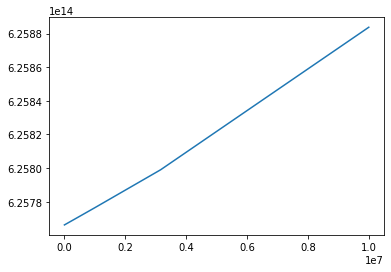

In [32]:
import matplotlib.pyplot as plt
plt.plot(np.logspace(1,7, num=13),RSS_list)

***QUIZ QUESTION***
Also, using this value of L1 penalty, how many nonzero weights do you have?

In [33]:
regression_model = turicreate.linear_regression.create(training, target="price",
                                              features=all_features,validation_set=None, 
                                                l2_penalty=0, l1_penalty = 10)

Linear regression:

--------------------------------------------------------

Number of examples          : 9761

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Max Error | Training Root-Mean-Square Error |

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

| 0         | 1        | 1.000000  | 0.010134     | 7700000.000000     | 662259.538545                   |

| 1         | 2        | 0.000003  | 0.303298     | 6287414.310279     | 322429.554621                   |

| 2         | 3        | 0.000003  | 0.329674     | 6004129.870008     | 303352.364502                   |

| 3         | 4        | 0.000003  | 0.356115     | 5888882.499599     | 298370.510858                   |

| 4         | 5        | 0.000003  | 0.383958     | 5813781.207975     | 293774.670687                   |

| 5         | 6        | 0.000003  | 0.412866     | 5737572.318059     | 289374.784200                   |

| 10        | 11       | 0.000003  | 0.544507     | 5329815.359960     | 273608.586502                   |

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

Completed (Iteration limit reached).

This model may not be optimal. To improve it, consider increasing `max_iterations`.

In [37]:
regression_model.coefficients.print_rows(18,4)

+------------------+-------+----------------------+--------+
|       name       | index |        value         | stderr |
+------------------+-------+----------------------+--------+
|   (intercept)    |  None |   18993.4272127706   |  None  |
|     bedrooms     |  None |  7936.9676790313015  |  None  |
| bedrooms_square  |  None |  936.9933681932994   |  None  |
|    bathrooms     |  None |  25409.588934120668  |  None  |
|   sqft_living    |  None |  39.11513637970764   |  None  |
| sqft_living_sqrt |  None |  1124.650212807717   |  None  |
|     sqft_lot     |  None | 0.003483618222989654 |  None  |
|  sqft_lot_sqrt   |  None |  148.25839101140826  |  None  |
|      floors      |  None |  21204.335466950117  |  None  |
|  floors_square   |  None |  12915.524336072433  |  None  |
|    waterfront    |  None |   601905.594545272   |  None  |
|       view       |  None |  93312.85731187189   |  None  |
|    condition     |  None |  6609.035712447216   |  None  |
|      grade       |  No

# Limit the number of nonzero weights

What if we absolutely wanted to limit ourselves to, say, 7 features? This may be important if we want to derive "a rule of thumb" --- an interpretable model that has only a few features in them.

In this section, you are going to implement a simple, two phase procedure to achive this goal:
1. Explore a large range of `l1_penalty` values to find a narrow region of `l1_penalty` values where models are likely to have the desired number of non-zero weights.
2. Further explore the narrow region you found to find a good value for `l1_penalty` that achieves the desired sparsity.  Here, we will again use a validation set to choose the best value for `l1_penalty`.

In [64]:
max_nonzeros = 7

## Exploring the larger range of values to find a narrow range with the desired sparsity

Let's define a wide range of possible `l1_penalty_values`:

In [56]:
l1_penalty_values = np.logspace(8, 10, num=20)
print (l1_penalty_values)

[1.00000000e+08 1.27427499e+08 1.62377674e+08 2.06913808e+08
 2.63665090e+08 3.35981829e+08 4.28133240e+08 5.45559478e+08
 6.95192796e+08 8.85866790e+08 1.12883789e+09 1.43844989e+09
 1.83298071e+09 2.33572147e+09 2.97635144e+09 3.79269019e+09
 4.83293024e+09 6.15848211e+09 7.84759970e+09 1.00000000e+10]


Now, implement a loop that search through this space of possible `l1_penalty` values:

* For `l1_penalty` in `np.logspace(8, 10, num=20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Extract the weights of the model and count the number of nonzeros. Save the number of nonzeros to a list.
        * *Hint: `model.coefficients['value']` gives you an SArray with the parameters you learned.  If you call the method `.nnz()` on it, you will find the number of non-zero parameters!* 

In [57]:
nnz_list=[]
for l1_penalty in l1_penalty_values:
    regression_model = turicreate.linear_regression.create(training, target = "price",
                                                          features = all_features, validation_set = None,
                                                          l2_penalty = 0, l1_penalty =l1_penalty, verbose=False)
    print(regression_model.coefficients['value'].nnz())

18
18
18
18
17
17
17
17
17
16
15
15
13
12
10
6
5
3
1
1


Out of this large range, we want to find the two ends of our desired narrow range of `l1_penalty`.  At one end, we will have `l1_penalty` values that have too few non-zeros, and at the other end, we will have an `l1_penalty` that has too many non-zeros.  

More formally, find:
* The largest `l1_penalty` that has more non-zeros than `max_nonzeros` (if we pick a penalty smaller than this value, we will definitely have too many non-zero weights)
    * Store this value in the variable `l1_penalty_min` (we will use it later)
* The smallest `l1_penalty` that has fewer non-zeros than `max_nonzeros` (if we pick a penalty larger than this value, we will definitely have too few non-zero weights)
    * Store this value in the variable `l1_penalty_max` (we will use it later)


*Hint: there are many ways to do this, e.g.:*
* Programmatically within the loop above
* Creating a list with the number of non-zeros for each value of `l1_penalty` and inspecting it to find the appropriate boundaries.

In [74]:

l1_penalty_min = 2.97635144e+09 
l1_penalty_max =  3.79269019e+09

***QUIZ QUESTION.*** What values did you find for `l1_penalty_min` and `l1_penalty_max`, respectively? 

## Exploring the narrow range of values to find the solution with the right number of non-zeros that has lowest RSS on the validation set 

We will now explore the narrow region of `l1_penalty` values we found:

In [75]:
l1_penalty_values = np.linspace(l1_penalty_min,l1_penalty_max,20)

* For `l1_penalty` in `np.linspace(l1_penalty_min,l1_penalty_max,20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Measure the RSS of the learned model on the VALIDATION set

Find the model that the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`.

In [77]:
RSS_list =[]
l1_list=[]
for l1_penalty in np.linspace(l1_penalty_min, l1_penalty_max, 20):
    regression_model = turicreate.linear_regression.create(training, target='price',
                                                          features=all_features, validation_set = None,
                                                          l2_penalty=0, l1_penalty = l1_penalty, verbose=False)
    print (regression_model.coefficients['value'].nnz())
    if regression_model.coefficients['value'].nnz() == max_nonzeros:
        prediction = regression_model.predict(validation)
        RSS = sum((validation["price"]-prediction)**2)
        RSS_list.append(RSS)
        l1_list.append(l1_penalty)
print(RSS_list, l1_list)
min(RSS_list)

10
10
10
10
10
10
10
10
8
8
8
7
7
7
7
6
6
6
6
6
[1046937488751713.5, 1051147625612863.0, 1055992735342998.9, 1060799531763289.9] [3448968611.0526314, 3491933808.421053, 3534899005.7894735, 3577864203.1578946]


1046937488751713.5

***QUIZ QUESTIONS***
1. What value of `l1_penalty` in our narrow range has the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`?
2. What features in this model have non-zero coefficients?

In [80]:
l1_penalty-3448968611.0526314

343721578.9473686

In [84]:
regression_model = turicreate.linear_regression.create(training, target='price',
                                                    features=all_features, validation_set = None,
                                                        l2_penalty=0, l1_penalty = l1_penalty, verbose=False)
print (regression_model.coefficients)


+------------------+-------+--------------------+--------+
|       name       | index |       value        | stderr |
+------------------+-------+--------------------+--------+
|   (intercept)    |  None | 240309.75931983022 |  None  |
|     bedrooms     |  None |        0.0         |  None  |
| bedrooms_square  |  None |        0.0         |  None  |
|    bathrooms     |  None | 13840.639957731408 |  None  |
|   sqft_living    |  None | 30.558358829777045 |  None  |
| sqft_living_sqrt |  None | 592.1994692127591  |  None  |
|     sqft_lot     |  None |        0.0         |  None  |
|  sqft_lot_sqrt   |  None |        0.0         |  None  |
|      floors      |  None |        0.0         |  None  |
|  floors_square   |  None |        0.0         |  None  |
+------------------+-------+--------------------+--------+
[18 rows x 4 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.
